# MNIST Data Exploration

#### About the data
* handwritten digits (0-9)
* each image 28 pixels x 28 pixels = 784 pixels in total
* pixel value is between 0 and 255, higher numbers meaning darker
* train data has 785 columns. First column: label, 784 columns: pixel values

## Packages

In [2]:
#standard data processing/visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

#keras
from keras.utils.np_utils import to_categorical #convert to 1-hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

## Import Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop('label',1) 

Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

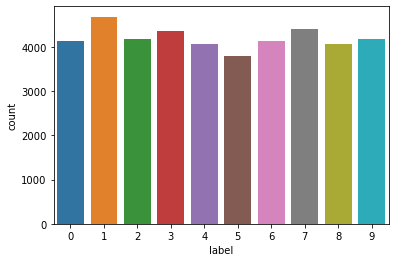

In [5]:
#digit counts are pretty well balanced
sns.countplot(Y_train)

In [12]:
#Check for nulls & missing values 
X_train.isnull().any().any()

False

In [13]:
test.isnull().any().any() #no missing values for train & test

False

## Data Preprocessing

In [15]:
#You can do a grayscale normalization (divide by 255) on the data to improve computing speed
X_train = X_train / 255.0
test = test / 255.0

In [20]:
#Images need to be reshaped into 3 dimensions (3D Matrices). 
#(height = 28px, width = 28px , channel = 1)
#for RGB images, you'd need 3 channels (28x28x3) 3D matrices
#for more explanation: https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
test = test.values.reshape(test.shape[0], 28, 28, 1)

In [21]:
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [24]:
## Label Encoding ##  
# Labels are encoded into one hot vectors
Y_train = to_categorical(Y_train, num_classes = 10)
#ex) 7 -> [0,0,0,0,0,0,1,0,0,0]

In [25]:
#Split training and validation sets
random_seed = 5
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  test_size = 0.1, random_state=random_seed)
#10% validation set

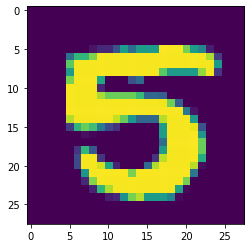

In [26]:
#view sample data
plt.imshow(X_train[0][:,:,0])

## CNN Model

In [29]:
#1st layer: convolutional layer (Conv2D) - set of learnable filters
#2nd layer: pooling layer (MaxPool2D) - "downsamples" filters by looking at 2 neighboring pixels and picks the maximal value. Reduces computational cost/overfitting
#Dropout: regularization method (a proportion of nodes are randomly ignored) - also improves generalization/reduce overfitting
#'relu' - rectifier (activation function max(0,x)) adds non linearity to the network
#Flatten layer convers final feature maps into a 1D vector. Combines all the found local features of the previous convolutional layers
#2 fully connected dense layers - classifier. Dense(10, activation='softmax') outputs probability of each class
#Useful resource: https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480

#used 32 filters for the first two Conv2D layers, and 64 filters for the next two 
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## Set optimizer, score function, and loss function

In [30]:
#Loss function: categorical cross entropy (>2 classes)
#Optimizer: iteratively improves parameters to minimize loss. Will use RMSprop
#score function: will use "Accuracy" as metric to evaluate the performance of the model
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [31]:
#Annealing can be used to make the optimizer converge faster
#Will have a decreasing Learning rate (LR)

#The ReduceLROnPlateau function reduces the LR by half if the accuracy is not improved after 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [32]:
epochs = 1 
batch_size = 86

In [34]:
#Try fitting model (pre-data augmentation) -> obtains 91% accuracy
model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 2)

357/357 - 55s - loss: 0.2724 - accuracy: 0.9150 - val_loss: 0.0703 - val_accuracy: 0.9785


## Data Augmentation

In [35]:
#Data augmentation helps avoid the overfitting problem by expanding the dataset artificially.
#Example of data augmentation: images are rotated, number is not centered, numbers are written big or small
#Other examples: color jitters, random crops, etc.

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally by 10% of width
        height_shift_range=0.1,  # randomly shift images vertically by 10% of height
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [37]:
#Finally, fit the model (post-absdata augmentation)# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

356/356 - 55s - loss: 0.1133 - accuracy: 0.9655 - val_loss: 0.0307 - val_accuracy: 0.9921


In [39]:
#Try again with epochs = 10
epochs = 10
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
356/356 - 54s - loss: 0.0760 - accuracy: 0.9770 - val_loss: 0.0307 - val_accuracy: 0.9900
Epoch 2/10
356/356 - 56s - loss: 0.0704 - accuracy: 0.9791 - val_loss: 0.0260 - val_accuracy: 0.9927
Epoch 3/10
356/356 - 54s - loss: 0.0660 - accuracy: 0.9812 - val_loss: 0.0238 - val_accuracy: 0.9935
Epoch 4/10
356/356 - 54s - loss: 0.0631 - accuracy: 0.9816 - val_loss: 0.0258 - val_accuracy: 0.9927
Epoch 5/10
356/356 - 54s - loss: 0.0592 - accuracy: 0.9824 - val_loss: 0.0294 - val_accuracy: 0.9921
Epoch 6/10
356/356 - 55s - loss: 0.0627 - accuracy: 0.9820 - val_loss: 0.0270 - val_accuracy: 0.9927
Epoch 7/10
356/356 - 53s - loss: 0.0574 - accuracy: 0.9832 - val_loss: 0.0241 - val_accuracy: 0.9915
Epoch 8/10
356/356 - 53s - loss: 0.0583 - accuracy: 0.9838 - val_loss: 0.0290 - val_accuracy: 0.9924
Epoch 9/10
356/356 - 53s - loss: 0.0548 - accuracy: 0.9837 - val_loss: 0.0295 - val_accuracy: 0.9927
Epoch 10/10
356/356 - 53s - loss: 0.0576 - accuracy: 0.9839 - val_loss: 0.0219 - val_accura

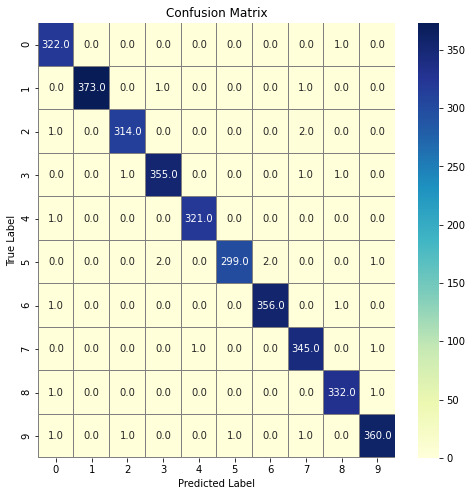

In [44]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [46]:
#Predict results
y_pred = model.predict(test)
y_pred = np.argmax(y_pred,axis = 1)

#Output results to CSV for submission
df_pred = pd.DataFrame(y_pred)
df_pred.index = range(1, 28001)
df_pred = df_pred.reset_index()
df_pred.head()
df_pred.columns = ["ImageId", "Label"]
df_pred.to_csv("submission_CNN.csv", index=False)